In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

# Parameters for the O2 budget
o2_2_no3 = 150/16
o2_2_nh4 = 118/16
o2_2_nfix = 130/16
o2_2_nitrif = 2
n_2_n_denit = 472/(5*16)
no3_2_nh4_amx = 3/5
seconds_per_year = 24*60*60*365

## Generate paths

In [2]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20241211/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/Eric.Stofferahn/CMIP7/ESM4/DEV/ESM4.5v01_om5b06_piC_khtr600_khth600/gfdl.ncrc5-intel23-prod-openmp/pp/'


In [3]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [4]:
# oxygen vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_o2'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')

In [5]:
# oxygen budget files
# oxygen cycle/nitrate fluxes
diag_type = 'ocean_cobalt_fluxes_int'
variables = ['wc_vert_int_jo2resp','wc_vert_int_juptake_no3','wc_vert_int_juptake_nh4','wc_vert_int_nfix',\
             'wc_vert_int_jprod_no3nitrif','wc_vert_int_jno3denit','wc_vert_int_jnamx',\
             'wc_vert_int_jno3_iceberg']

flux_vertint_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
flux_vertint_files = sorted([f for fi in flux_vertint_files for f in fi]) # nested list comprehension

In [6]:
# oxygen flux files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['o2_stf_gas','runoff_flux_ldon','runoff_flux_sldon','runoff_flux_srdon','runoff_flux_ndet']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension

In [7]:
# oxygen flux files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
variables = ['fnoxic_sed','fnfeso4red_sed','fn_burial','fno3denit_sed']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension

## Read in files

In [8]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [9]:
flux = xr.open_mfdataset(flux_vertint_files, combine='by_coords')

In [10]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [11]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

## Compute Global Inventory

These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [12]:
global_total = (total.wc_vert_int_o2 * grid.areacello).sum(dim=['xh','yh'])

Text(0.5, 1.0, 'Global Oxygen inventory (Pmol)')

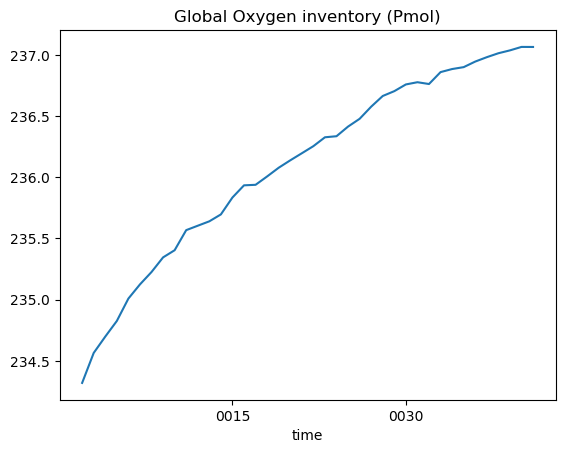

In [13]:
(global_total/1e15).plot()
plt.title('Global Oxygen inventory (Pmol)')

## Compute Fluxes

In [14]:
# creation of O2 via NPP
npp_no3 = flux.wc_vert_int_juptake_no3 * o2_2_no3
npp_nh4 = flux.wc_vert_int_juptake_nh4 * o2_2_nh4
npp_nfix = flux.wc_vert_int_nfix * o2_2_nh4 # in the code this is used instead of a nitrogen fixation specific stoichiometry

o2_from_npp = (npp_no3 + npp_nh4 + npp_nfix)
o2_from_npp = (o2_from_npp * grid.areacello).sum(dim=['xh','yh'])
o2_from_npp = o2_from_npp * seconds_per_year

In [15]:
# oxygen respiration
o2resp = (flux.wc_vert_int_jo2resp * grid.areacello).sum(dim=['xh','yh'])
o2resp = o2resp * seconds_per_year

# nitrification consumes oxygen but it is included in jo2resp

In [16]:
# air-sea exchange
o2_stf_gas = (surf.o2_stf_gas * grid.areacello).sum(dim=['xh','yh'])
o2_stf_gas = o2_stf_gas * seconds_per_year

In [17]:
# sediments - aerobic and anaerobic remineralization
sediments = btm.fnoxic_sed #+ btm.fnfeso4red_sed
sediments = (sediments * grid.areacello).sum(dim=['xh','yh'])
sediments = sediments * o2_2_nh4 * seconds_per_year

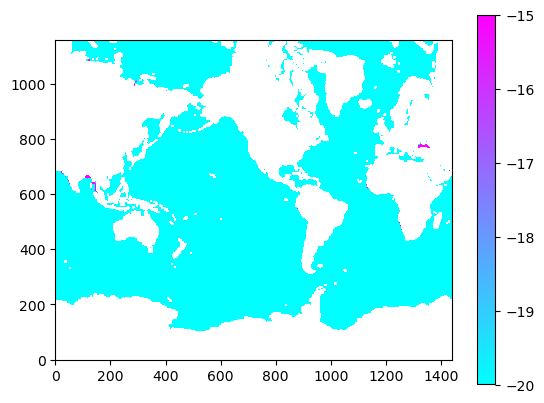

In [18]:
plt.imshow(np.log10(btm.fnfeso4red_sed.mean(dim='time').values), origin='lower', vmin=-20,vmax=-15, cmap='cool')
plt.colorbar()

Unclear if the rest, below, is needed at all

In [19]:
# sediments - oxygen consumption from burial
burial = (btm.fn_burial * grid.areacello).sum(dim=['xh','yh'])
burial = burial * o2_2_nh4 * seconds_per_year

In [20]:
# denitrification
# denitrification removes no3 from the system that otherwise would get remineralized
denit = flux.wc_vert_int_jno3denit + btm.fno3denit_sed
denit = (denit * grid.areacello).sum(dim=['xh','yh'])
denit = denit * o2_2_no3 * seconds_per_year

In [21]:
# anammox
# anammox removes nh4 and no3 from the system that otherwise would get remineralized
# here only focus on the nh4
nh4amx = flux.wc_vert_int_jnamx

# jamx = juptake_no3amx + juptake_nh4amx
# juptake_no3amx = juptake_nh4amx * no3_2_nh4_amx
# jamx = (1+no3_2_nh4_amx)*juptake_nh4amx; juptake_nh4amx = jamx/(1+no3_2_nh4_amx)

nh4amx = nh4amx / (1+no3_2_nh4_amx)
nh4amx = (nh4amx * grid.areacello).sum(dim=['xh','yh'])
nh4amx = nh4amx * o2_2_nh4 * seconds_per_year

In [22]:
# riverine inputs
total_runoff = (surf.runoff_flux_ldon + surf.runoff_flux_sldon + surf.runoff_flux_srdon + surf.runoff_flux_ndet) * o2_2_nh4
# excluding nitrogen detritus?

total_runoff = (total_runoff * grid.areacello).sum(dim=['xh','yh'])
total_runoff = total_runoff * seconds_per_year

In [23]:
# icebergs
iceberg = (flux.wc_vert_int_jno3_iceberg * grid.areacello).sum(dim=['xh','yh']) 
iceberg = iceberg * o2_2_no3 * seconds_per_year

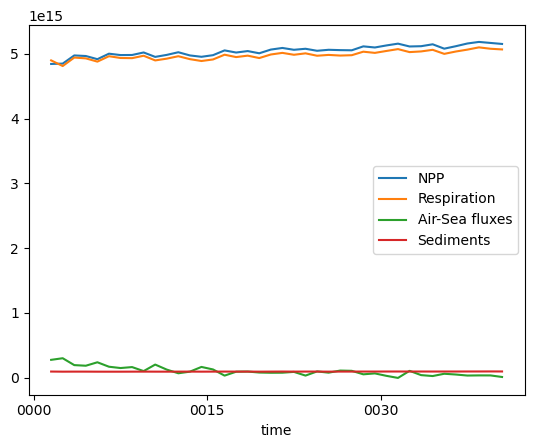

In [24]:
o2_from_npp.plot()
o2resp.plot()
o2_stf_gas.plot()
sediments.plot()
#total_runoff.plot()
#iceberg.plot()
plt.legend(['NPP','Respiration','Air-Sea fluxes','Sediments','Rivers','Icebergs'])

Text(0.5, 1.0, 'Net oxygen fluxes (moles)')

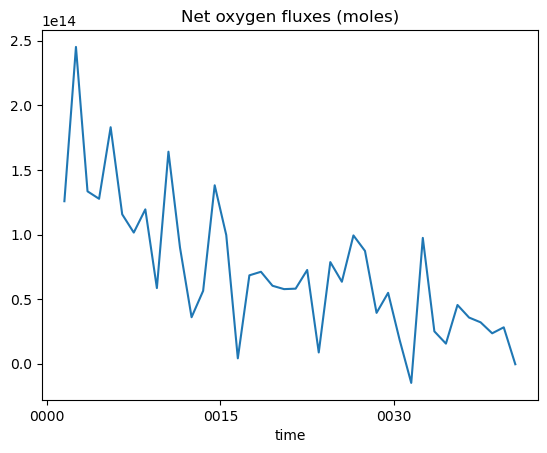

In [25]:
net_flux = o2_from_npp - o2resp + o2_stf_gas - sediments# + burial - total_runoff - iceberg #+ nh4amx
net_flux.plot()
plt.title('Net oxygen fluxes (moles)')

## Close budgets
The total carbon inventory should be equal to the starting inventory plus the carbon fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_c term is saved at the end of year 1

Text(0.5, 1.0, 'Oxygen fluxes as calculated by the change in the global O2 inventory')

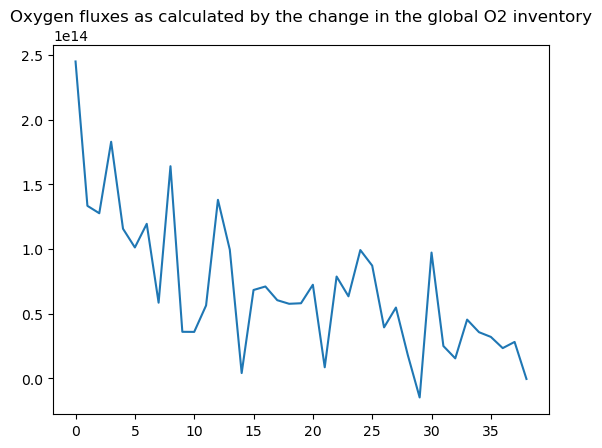

In [26]:
plt.plot(np.diff(global_total))
plt.title('Oxygen fluxes as calculated by the change in the global O2 inventory')

In [27]:
np.diff(global_total.values)

array([ 2.4507083e+14,  1.3347040e+14,  1.2773233e+14,  1.8299997e+14,
        1.1575796e+14,  1.0129251e+14,  1.1955471e+14,  5.8583354e+13,
        1.6410211e+14,  3.6077725e+13,  3.6009006e+13,  5.6453050e+13,
        1.3812615e+14,  9.9557342e+13,  4.1918881e+12,  6.8410239e+13,
        7.1107479e+13,  6.0524679e+13,  5.7741540e+13,  5.8153857e+13,
        7.2464688e+13,  8.6586541e+12,  7.8804060e+13,  6.3513976e+13,
        9.9282464e+13,  8.7239376e+13,  3.9513699e+13,  5.4838142e+13,
        1.8141942e+13, -1.4688788e+13,  9.7341139e+13,  2.5082609e+13,
        1.5547782e+13,  4.5509473e+13,  3.5785668e+13,  3.2143535e+13,
        2.3467701e+13,  2.8260885e+13, -3.7795712e+11], dtype=float32)

In [28]:
net_flux.values[1:]

array([ 2.45189869e+14,  1.33439562e+14,  1.27652044e+14,  1.83041748e+14,
        1.15642693e+14,  1.01521708e+14,  1.19474120e+14,  5.85672164e+13,
        1.64112469e+14,  8.98513620e+13,  3.60082621e+13,  5.64231469e+13,
        1.38108593e+14,  9.95718058e+13,  4.19935347e+12,  6.84275460e+13,
        7.11767520e+13,  6.03565375e+13,  5.77569856e+13,  5.81167089e+13,
        7.25741516e+13,  8.74666334e+12,  7.86615220e+13,  6.34606024e+13,
        9.93201249e+13,  8.73059259e+13,  3.93831186e+13,  5.48843517e+13,
        1.82858382e+13, -1.48323988e+13,  9.74047071e+13,  2.50764180e+13,
        1.55782873e+13,  4.54825398e+13,  3.57635427e+13,  3.20560326e+13,
        2.35619411e+13,  2.82017776e+13, -3.78911938e+11])

Text(0.5, 1.0, 'Global oxygen inventory (Pmol)')

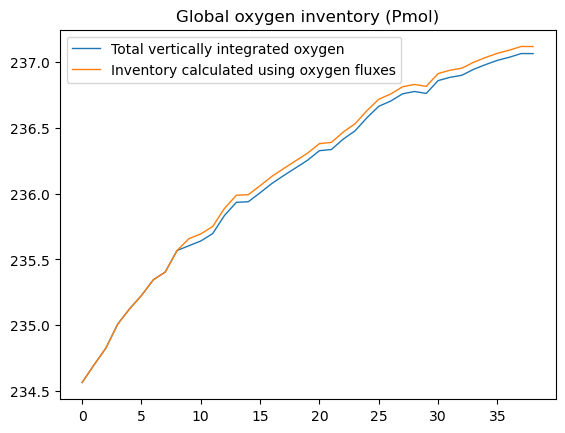

In [29]:
plt.plot(global_total.values[1:]/1e15, linewidth=1)
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0])/1e15, linewidth=1)
plt.legend(['Total vertically integrated oxygen','Inventory calculated using oxygen fluxes'])
plt.title('Global oxygen inventory (Pmol)')

Text(0.5, 1.0, 'Total global oxygen inventory imbalance')

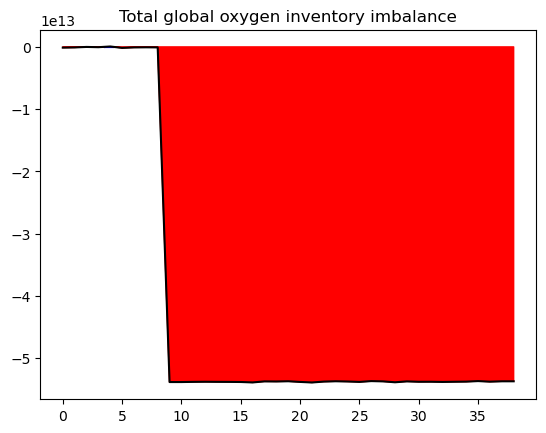

In [30]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global oxygen inventory imbalance')

Text(0.5, 1.0, 'Total global oxygen flux imbalance')

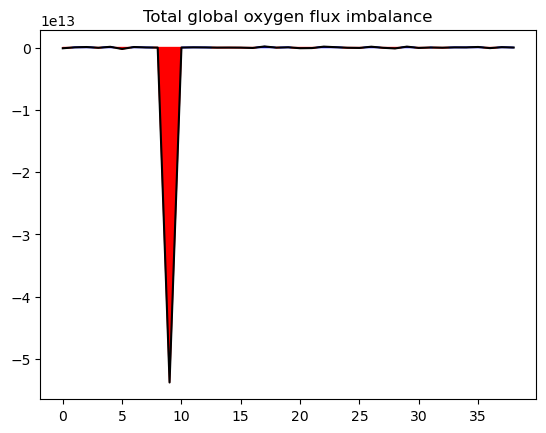

In [31]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values) - net_flux.values[1:])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global oxygen flux imbalance')